In [41]:
# System
import sys, os
import warnings
import shutil
from tqdm.autonotebook import tqdm
sys.path.append('//Users//KattPaint//Desktop//DATASCI266//Modern-Time-Series-Forecasting-with-Python')
from src.utils.general import LogTime
import joblib
from pathlib import Path

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from itertools import cycle
#import seaborn as sns
import plotly.io as pio
#from src.utils import plotting_utils
from IPython.display import display, HTML

# Modeling
from darts.models import RegressionModel, RandomForest, TFTModel, NBEATSModel, BlockRNNModel
from sklearn.linear_model import Ridge
from darts.timeseries import TimeSeries
from darts.metrics import mase, mse, mae, ope, mape
from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler
from darts.models.forecasting.linear_regression_model import LinearRegressionModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.utils.losses import MAELoss

# Global Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.random.seed(42)
tqdm.pandas()

# Defined Functions

In [35]:
def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    # colors = ["rgba("+",".join([str(c) for c in plotting_utils.hex_to_rgb(c)])+",<alpha>)" for c in px.colors.qualitative.Plotly]
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    # colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Safe]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash","dot","dashdot"])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df[mask].t10yr,
                        mode='lines', line = dict(color=act_color.replace("<alpha>", "0.3")),
                        name='Actual 10YT'))
    for col, display_col in zip(forecast_columns,forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df.loc[mask, col],
                            mode='lines', line = dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "1")),
                            name=display_col))
    return fig

def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred

def eval_model(y_pred, val_test, name=None):
    return {
        "Algorithm": name,
        "MAE": mae(actual_series = val_test, pred_series = y_pred),
        "MSE": mse(actual_series = val_test, pred_series = y_pred),
        "MAPE": mape(actual_series = val_test, pred_series = y_pred)
    }

# Import Data

In [45]:
data = pd.read_csv('../data/monthly_target_economic_factors.csv')
data = data.rename({'Unnamed: 0':'time_index'}, axis=1)
data.index = pd.to_datetime(data.time_index)
data = data.drop(['time_index', 'month'], axis=1)

data.head()

t10yr  cpi  unemp   ppi  saving
time_index                                 
1970-01-01   7.79 0.27   3.90 36.50   11.80
1970-02-01   7.24 0.53   4.20 36.70   11.70
1970-03-01   7.07 0.53   4.40 36.70   12.40
1970-04-01   7.39 0.79   4.60 36.80   13.30
1970-05-01   7.91 0.26   4.80 36.80   12.40

# Train / Validation / Test

In [46]:
# define variables for prediction 
horizon = 24 # prediction horizon 
look_back = int(horizon / 2) # number of lags to use 

# convert to time series object 
data_ts = TimeSeries.from_dataframe(data)

# train/val/test split 
train_split = (horizon + look_back) * 2
test_split = (horizon + look_back)

# split into dataframes 
train = data[:-train_split]
val = data[-train_split:-test_split]
test = data[-test_split:]

# split into dataframes for ts 
train_ts = data_ts[:-train_split]
val_ts = data_ts[-train_split:-test_split]
test_ts = data_ts[-test_split:]

# print time stamps 
print("Split Timestamps:")
print(f"Train Min: {train_ts.time_index.min()} | Train Max: {train_ts.time_index.max()}")
print(f"Val Min: {val_ts.time_index.min()} | Val Max: {val_ts.time_index.max()}")
print(f"Test Min: {test_ts.time_index.min()} | Test Max: {test_ts.time_index.max()}")

Split Timestamps:
Train Min: 1970-01-01 00:00:00 | Train Max: 2018-03-01 00:00:00
Val Min: 2018-04-01 00:00:00 | Val Max: 2021-03-01 00:00:00
Test Min: 2021-04-01 00:00:00 | Test Max: 2024-03-01 00:00:00


In [47]:
# split target and covariates 
target = 't10yr'
past_covariates = ['cpi', 'unemp', 'ppi', 'saving']

train_targ, train_past_cov = train_ts[target], train_ts[past_covariates]
val_targ, val_past_cov = val_ts[target], val_ts[past_covariates]
test_targ, test_past_cov = test_ts[target], test_ts[past_covariates]

# Scaling / Normalization

In [48]:
# initialize scaler 
scaler = MinMaxScaler()
targ_transformer = Scaler(scaler)
cov_transformer = Scaler(scaler)

# fit scaler 
targ_scaler = targ_transformer.fit(train_targ)
cov_scaler = cov_transformer.fit(train_past_cov)

# transform data 
train_targ_sc, train_past_cov_sc = targ_scaler.transform(train_targ), cov_scaler.transform(train_past_cov)
val_targ_sc, val_past_cov_sc = targ_scaler.transform(val_targ), cov_scaler.transform(val_past_cov)
test_targ_sc, test_past_cov_sc = targ_scaler.transform(test_targ), cov_scaler.transform(test_past_cov)

# Linear Regression

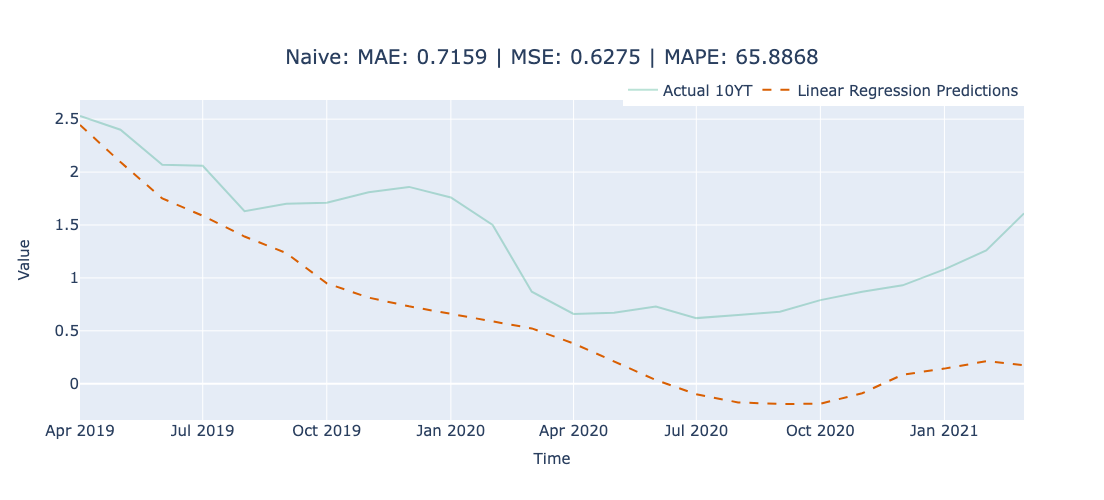

In [49]:
# initialize model 
model = LinearRegressionModel(
    lags=look_back,
    lags_past_covariates=look_back,
    output_chunk_length=horizon,
)

# fit model on training data 
model.fit(train_targ_sc, past_covariates=train_past_cov_sc)

# predict on validation data 
pred_sc = model.predict(horizon, series=val_targ_sc[:-horizon], past_covariates=val_past_cov_sc[:-horizon])

# dataframes for evaluation 
pred_df = pd.concat([train[[target]], val[[target]]])
metric_record = []

# evaluation
pred = targ_scaler.inverse_transform(pred_sc)
metrics = eval_model(pred, val_targ[-horizon:], 'Linear Regression')
metric_record.append(metrics)

y_pred = format_y_pred(pred, "lr_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["lr_predictions"], forecast_display_names=['Linear Regression Predictions'])
fig = format_plot(fig, title=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MAPE: {metrics['MAPE']:.4f}")
fig.show()

# Ridge Regression

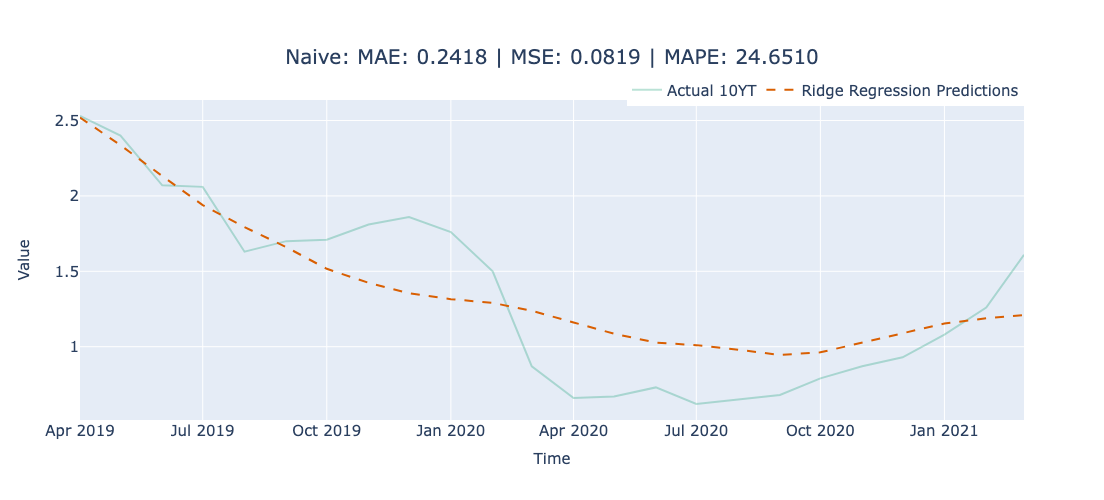

In [50]:
# initialize model 
model = RegressionModel(
    model=Ridge(),
    lags=look_back,
    lags_past_covariates=look_back,
    output_chunk_length=horizon
)

# fit model on training data 
model.fit(train_targ_sc, past_covariates=train_past_cov_sc)

# predict on validation data 
pred_sc = model.predict(horizon, series=val_targ_sc[:-horizon], past_covariates=val_past_cov_sc[:-horizon])

# evaluation
pred = targ_scaler.inverse_transform(pred_sc)
metrics = eval_model(pred, val_targ[-horizon:], 'Ridge Regression')
metric_record.append(metrics)

y_pred = format_y_pred(pred, "rr_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["rr_predictions"], forecast_display_names=['Ridge Regression Predictions'])
fig = format_plot(fig, title=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MAPE: {metrics['MAPE']:.4f}")
fig.show()

# Random Forest

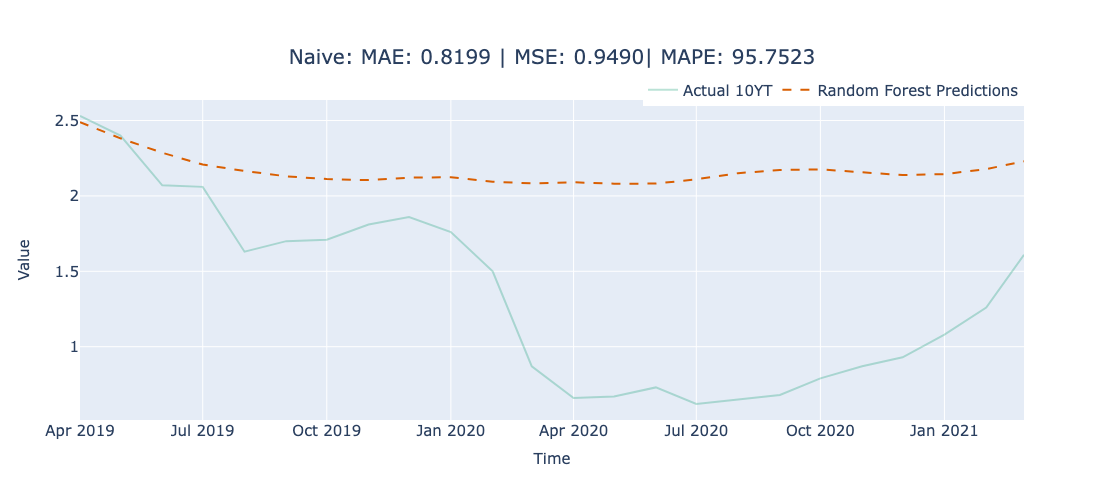

In [51]:
# initialize model 
model = RandomForest(
    lags=look_back,
    lags_past_covariates=look_back,
    output_chunk_length=horizon
)

# fit model on training data 
model.fit(train_targ_sc, past_covariates=train_past_cov_sc)

# predict on validation data 
pred_sc = model.predict(horizon, series=val_targ_sc[:-horizon], past_covariates=val_past_cov_sc[:-horizon])

# evaluation
pred = targ_scaler.inverse_transform(pred_sc)
metrics = eval_model(pred, val_targ[-horizon:], 'Random Forest Regression')
metric_record.append(metrics)

y_pred = format_y_pred(pred, "rf_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["rf_predictions"], forecast_display_names=['Random Forest Predictions'])
fig = format_plot(fig, title=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f}| MAPE: {metrics['MAPE']:.4f}")
fig.show()

# Temporal Fusion Transformer 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 104 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 16.9 K | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork 

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

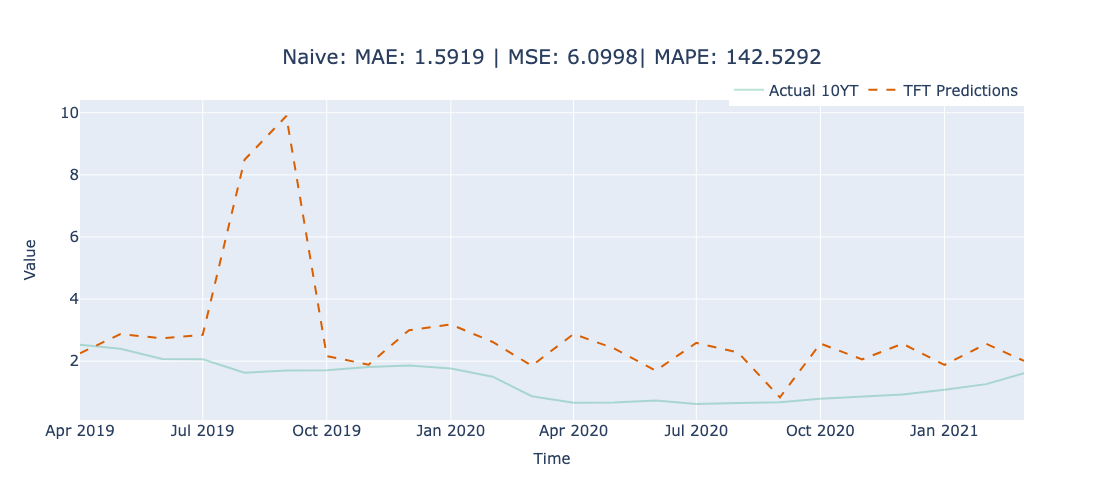

In [52]:
# initialize model 
model = TFTModel(
    input_chunk_length=look_back,
    #lags_past_covariates=look_back,
    output_chunk_length=horizon,
    n_epochs=25,
    add_relative_index=True, # allows us to not specify future covariates 
    num_attention_heads=4,
    dropout=0.1,
    hidden_size=64,
    hidden_continuous_size=64,
    batch_size=64
)

# fit model on training data 
model.fit(train_targ_sc, past_covariates=train_past_cov_sc)

# predict on validation data 
pred_sc = model.predict(horizon, series=val_targ_sc[:-horizon], past_covariates=val_past_cov_sc[:-horizon])

# evaluation
pred = targ_scaler.inverse_transform(pred_sc)
metrics = eval_model(pred, val_targ[-horizon:], 'TFT Regression')
metric_record.append(metrics)

y_pred = format_y_pred(pred, "tft_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["tft_predictions"], forecast_display_names=['TFT Predictions'])
fig = format_plot(fig, title=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f}| MAPE: {metrics['MAPE']:.4f}")
fig.show()

- Maybe less appropraite due to lack of future covariates 

# N-BEATS

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.5 M  | train
-------------------------------------------------------------
6.5 M     Trainable params
1.6 K     Non-trainable params
6.5 M     Total params
25.997    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

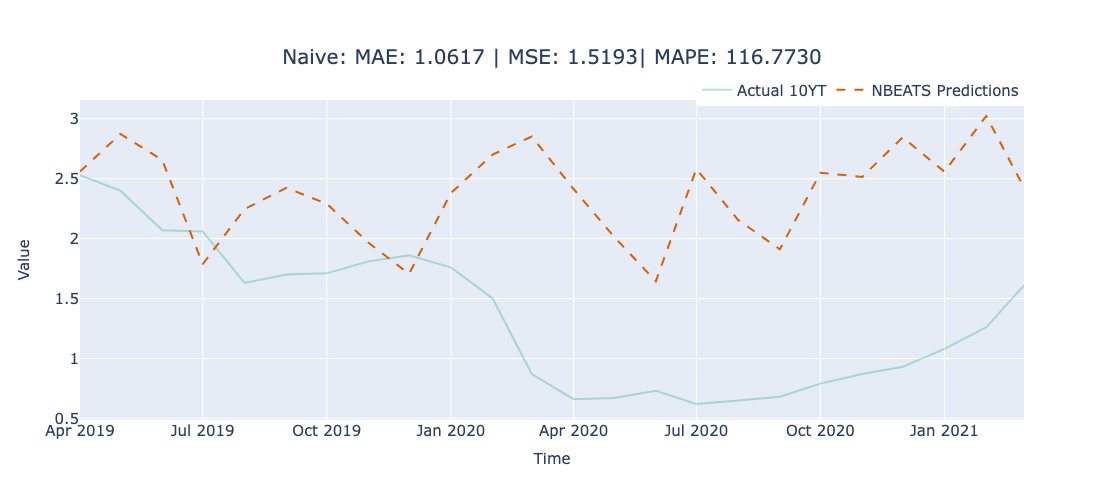

In [53]:
# initialize model 
model = NBEATSModel(
    input_chunk_length=look_back,
    output_chunk_length=horizon,
    n_epochs=10,
    activation='LeakyReLU',
    batch_size=64,
)

# fit model on training data 
model.fit(train_targ_sc, past_covariates=train_past_cov_sc)

# predict on validation data 
pred_sc = model.predict(horizon, series=val_targ_sc[:-horizon], past_covariates=val_past_cov_sc[:-horizon])

# evaluation
pred = targ_scaler.inverse_transform(pred_sc)
metrics = eval_model(pred, val_targ[-horizon:], 'NBEATS Regression')
metric_record.append(metrics)

y_pred = format_y_pred(pred, "nb_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["nb_predictions"], forecast_display_names=['NBEATS Predictions'])
fig = format_plot(fig, title=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f}| MAPE: {metrics['MAPE']:.4f}")
fig.show()

# LSTM

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 656    | train
6 | fc              | Sequential       | 120    | train
-------------------------------------------------------------
776       Trainable params
0         Non-trainable params
776       Total params
0.003     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

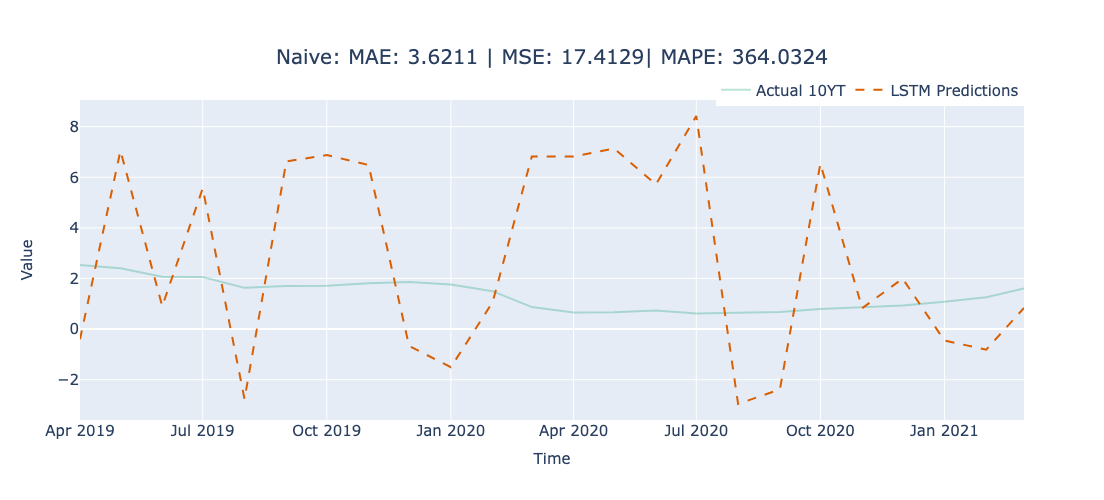

In [54]:
# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.01,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper]}

# initialize model 
model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=look_back,
    output_chunk_length=horizon,
    n_epochs=50,
    n_rnn_layers=4,
    hidden_dim=4,
    dropout=0.1,
    activation='LeakyReLU',
    batch_size=64,
    optimizer_kwargs={"lr":0.001},
    pl_trainer_kwargs=pl_trainer_kwargs,
    #loss_fn=MAELoss()
)

# fit model on training data 
model.fit(train_targ_sc, past_covariates=train_past_cov_sc, val_series=val_targ_sc, val_past_covariates=val_past_cov_sc)

# predict on validation data 
pred_sc = model.predict(horizon, series=val_targ_sc[:-horizon], past_covariates=val_past_cov_sc[:-horizon])

# evaluation
pred = targ_scaler.inverse_transform(pred_sc)
metrics = eval_model(pred, val_targ[-horizon:], 'LSTM Regression')
metric_record.append(metrics)

y_pred = format_y_pred(pred, "lstm_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["lstm_predictions"], forecast_display_names=['LSTM Predictions'])
fig = format_plot(fig, title=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f}| MAPE: {metrics['MAPE']:.4f}")
fig.show()

# Comparison

In [55]:
metric_df = pd.DataFrame(metric_record)
metric_styled = metric_df.style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "MAPE": "{:.3f}"}).highlight_min(color='lightgreen', subset=["MAE","MSE", "MAPE"])

display(metric_styled)